## Import Libraries

In [1]:
 !pip install pycirclize
 !pip install country_converter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 KB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import country_converter as coco

from pycirclize import Circos
from pycirclize.parser import Matrix

## Loading Dataset

In [3]:
df = pd.read_csv('data/merged.csv')
df.head(3)

,id,firstname,surname,born,died,bornCountry,bornCountryCode,bornCity,diedCountry,diedCountryCode,...,gender,year,category,overallMotivation,share,motivation,name,city,country,prizeAge
0,1,Wilhelm Conrad,Röntgen,1845,1923,Prussia (now Germany),DE,Lennep (now Remscheid),Germany,DE,...,male,1901,physics,NaN,1,"""in recognition of the extraordinary services ...",Munich University,Munich,Germany,56
1,2,Hendrik A.,Lorentz,1853,1928,the Netherlands,NL,Arnhem,the Netherlands,NL,...,male,1902,physics,NaN,2,"""in recognition of the extraordinary service t...",Leiden University,Leiden,the Netherlands,49
2,3,Pieter,Zeeman,1865,1943,the Netherlands,NL,Zonnemaire,the Netherlands,NL,...,male,1902,physics,NaN,2,"""in recognition of the extraordinary service t...",Amsterdam University,Amsterdam,the Netherlands,37


In [4]:
df.shape

(989, 21)

## Chord Diagram


Inspired by this recourse:
https://moshi4.github.io/pyCirclize/chord_diagram/#2-2-example-2

In [6]:
# Supplimentary function to create 'from-to' dataframe & convert it to matrix
# Input: df of Nobel Prizes
# Return: Matrix

def create_circos_matrix(df):
  fromto_table = []
  
  for index, row in df.iterrows():
    # We will compare the country of birth and the country of university
    bornCountryCode = row['bornCountryCode']
    country = row['country']

    if country!=country: # if 'country' is nan, we assume the person didn't go to other country for the reseach 
      fromto_table.append([bornCountryCode, bornCountryCode]) 
    elif country=='Germany (now France)': # the person from 'Germany (now France)' didn't go to other country for the reseach
      fromto_table.append([bornCountryCode, 'Germany'])   
    else:
      fromto_table.append([bornCountryCode, country])

  # Counting number of "from - to" pairs 
  fromto_table_df = pd.Series(fromto_table).value_counts()
  fromto_table_df = fromto_table_df.reset_index(name='number_of_cases').rename(columns = {'index':'from_to'})
  fromto_table_df[['from','to']] = pd.DataFrame(fromto_table_df.from_to.tolist())

  # Converting destination country to the same format as the country origin
  cc = coco.CountryConverter()
  fromto_table_df['to'] = cc.convert(fromto_table_df['to'], to='ISO2')

  # Keeping only 3 columns and in specific order: 'from', 'to', 'number_of_cases'
  fromto_table_df.drop(columns=['from_to'], inplace=True)
  fromto_table_df = fromto_table_df[['from', 'to', 'number_of_cases']]

  if fromto_table_df.shape[0]>100:
    matrix = Matrix.parse_fromto_table(fromto_table_df[fromto_table_df['number_of_cases']>1])
  else:
    matrix = Matrix.parse_fromto_table(fromto_table_df) 
  return matrix

In [7]:
matrix = create_circos_matrix(df)

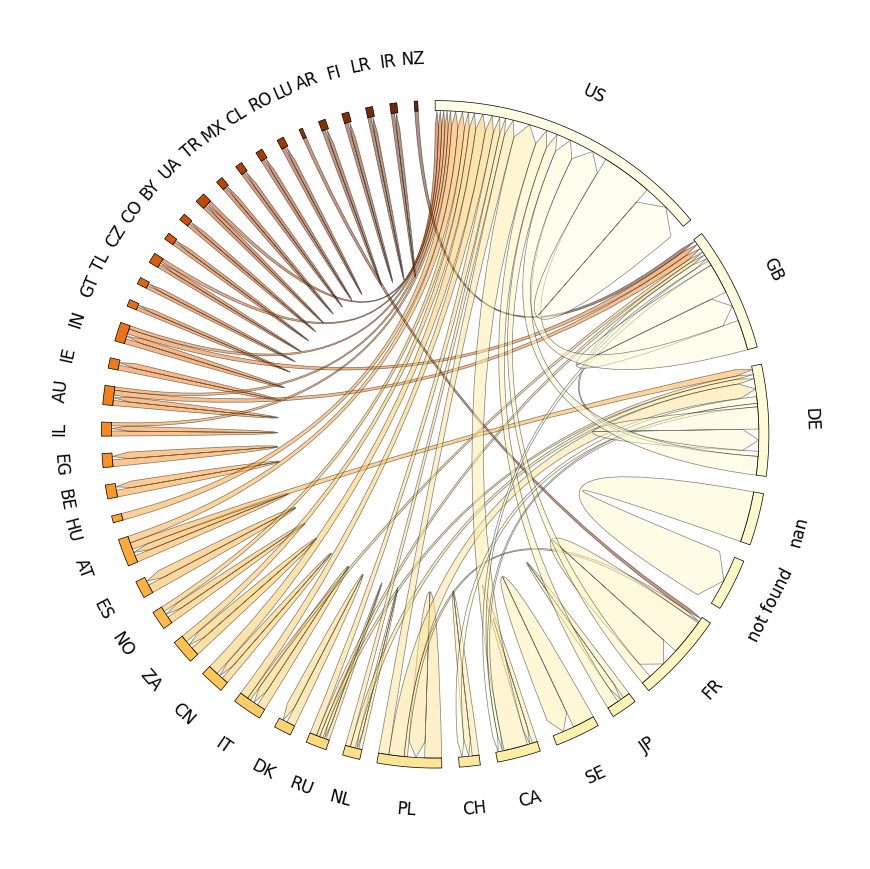

In [9]:
circos = Circos.initialize_from_matrix(
    matrix,
    space=3,
    #cmap="viridis",
    cmap ='YlOrBr',
    #ticks_interval=3,
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)

#print(fromto_table_df.to_string(index=False))
fig = circos.plotfig()

In [10]:
type(fig)

matplotlib.figure.Figure

## Chord Diagram highlighting Specific Desctinations

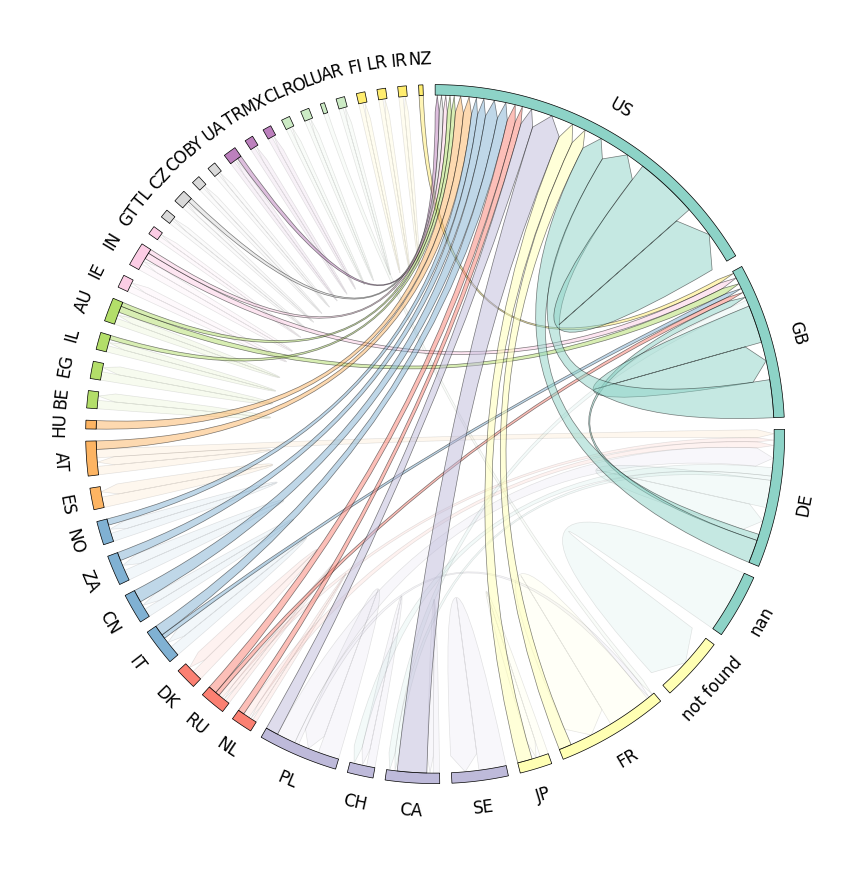

In [11]:
highlight_list  = ("US", "GB") # OR list(fromto_table_df.iloc[:5, 1]) 

# Define link_kws handler function to customize each link property
def link_kws_handler(from_label: str, to_label: str):
    if to_label in highlight_list:
        # Set alpha, zorder values higher than other links for highlighting
        return dict(alpha=0.5, zorder=1.0)
    else:
        return dict(alpha=0.1, zorder=0)

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
    matrix,
    space=2,
    cmap="Set3",
    label_kws=dict(size=12),
    link_kws=dict(direction=1, ec="black", lw=0.5),
    link_kws_handler=link_kws_handler,
)

fig = circos.plotfig()

In [ ]:
## Generating pictures for dashboard

In [12]:
science_options = ['All Sciences', 'Physics', 'Chemistry', 'Medicine', 'Economics']
default_science = "All Sciences"

In [17]:
def create_circle_picture(chosen_category):
    if chosen_category==default_science:
        chosen_df = df.loc[(df['gender']!='org')]
    else:
        chosen_df = df.loc[(df['gender']!='org') & (df['category']==chosen_category.lower())]
      
    matrix = create_circos_matrix(chosen_df)

    highlight_list  = ("US") #"GB") # OR list(fromto_table_df.iloc[:5, 1]) 

    # Initialize from matrix (Can also directly load tsv matrix file)
    circos = Circos.initialize_from_matrix(
        matrix,
        space=4,
        cmap ='YlOrBr',
        label_kws=dict(size=12),
        link_kws=dict(direction=1, ec="black", lw=1),
        link_kws_handler=link_kws_handler,
    )

    fig = circos.plotfig()
    fig.savefig(chosen_df+'US'+'.png')

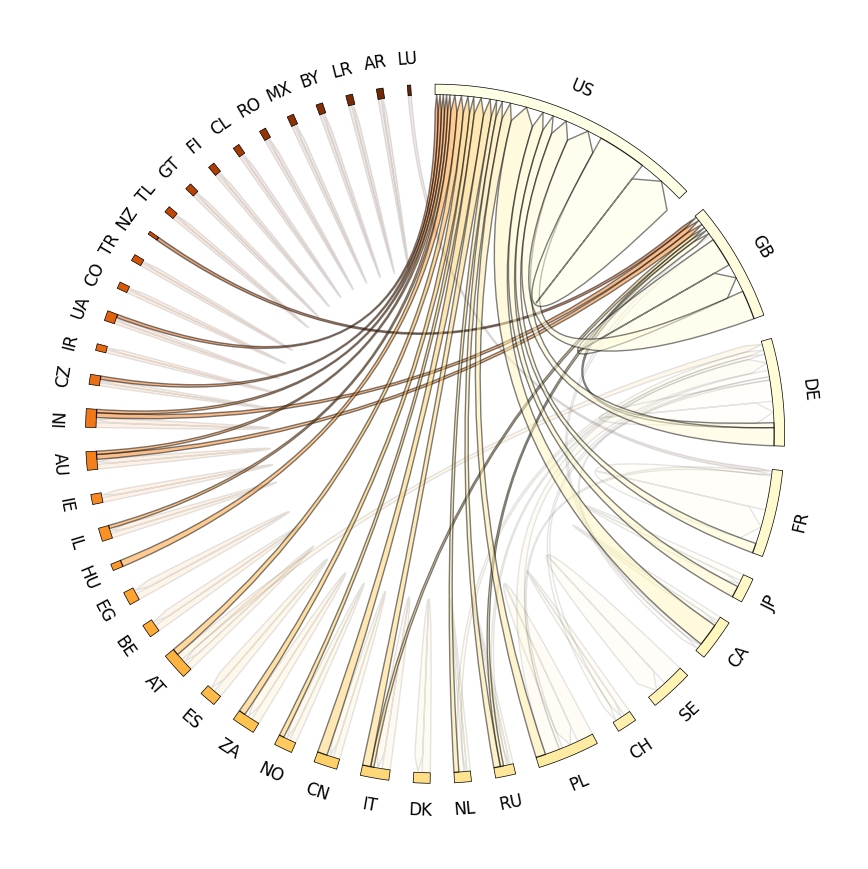

In [16]:
create_circle_picture('All Sciences')

In [ ]:
fig.savefig('assets/2.png')